In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Here, I will import the necessary libraries needed for this program
import cv2
import math
from google.colab.patches import cv2_imshow
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# This function will get the path of an image as an input parameter and return
# the image as a numpy array to the caller
def get_image(path):
  # Read an image as greyscale
  image1 = cv2.imread(path, 0)
  return image1

In [ ]:
# This function will return a box_kernel of the desired size
def get_box_kernel(size):
  kernel = np.ones((size, size), np.float32) / (size**2)
  return kernel

In [ ]:
# This function will create and return a 2D gaussian filter
def create_gauss_filter(kernel_size, sigma):
  kernel_radius = int(np.floor(kernel_size / 2))
  # This will return two 2D arrays representing our grid
  x, y = np.meshgrid(np.linspace(-kernel_radius, kernel_radius, kernel_size), np.linspace(-kernel_radius, kernel_radius, kernel_size))
  # Take the square root of the sum of squared arrays
  dst = np.sqrt(np.square(x) + np.square(y))

  # Here, we will create the 2D gaussian filter and return it to the caller
  gauss = np.exp(-( (dst)**2 / ( 2.0 * sigma**2 ) ) )
  return gauss

In [ ]:
# This function will create and return a 1D gaussian filter
def create_1Dgaussian_kernel(kernel_size, sigma):
  kernel_radius = int(np.floor(kernel_size / 2))

  # Generate the 1D gaussian filter using the formula given in class
  gauss_kernel = np.linspace(-kernel_radius, kernel_radius, kernel_size)
  gauss_kernel = (1 / (np.sqrt(2 * np.pi) * sigma)) * \
                      np.e ** (-np.power((gauss_kernel) / sigma, 2) / 2)
  gauss_kernel = np.divide(gauss_kernel, np.sum(gauss_kernel))

  return gauss_kernel

In [ ]:
# This function will compute the gradient magnitude of two images
def compute_gradient_magnitude(image1, image2):
  gradient_magnitude = np.hypot(image1,image2)
  gradient_magnitude = np.divide(gradient_magnitude, gradient_magnitude.max())
  gradient_magnitude = np.multiply(gradient_magnitude, 255)

  return gradient_magnitude

In [ ]:
# This function will adjust the derivative images to be used when displaying results
def adjust_derivative_images(img_x, img_y):
  img_x = np.abs(img_x)
  img_y = np.abs(img_y)

  img_x = ((img_x - np.min(img_x)) / (np.max(img_x) - np.min(img_x)) * 255).astype(np.uint8)
  img_y = ((img_y - np.min(img_y)) / (np.max(img_y) - np.min(img_y)) * 255).astype(np.uint8)

  return (img_x, img_y)

In [ ]:
# This function will take in an image and creating its resulting histogram with
# a specified number of bins
def plot_histogram(image, num_bins):
  img_height, img_width = image.shape
  bin_count = np.zeros((num_bins))
  bin_size = int(256 / num_bins)

  for row in range(0, img_height):
    for col in range(0, img_width):
      this_bin = image[row, col] // bin_size
      bin_count[this_bin] += 1

  plt.figure()
  plt.bar(np.arange(num_bins), bin_count)
  plt.show()

  return bin_count

In [ ]:
# This function takes an image, and kernel as input parameters and performs
# 2D convolution for each filter on the image using a box filter. Returns the
# filtered image
def apply_filter(image, kernel):
  # We want to get the different dimensions of our input image, the kernel radius
  # to help with looping over the image
  img_height, img_width = image.shape
  kernel_radius = int(np.floor(kernel.shape[0] / 2))
  
  # This creates a numpy array that will hold the blurred image after convolution
  filtered_img = np.zeros((img_height, img_width))

  # Now, we will flip the kernel so we can use it for our 2D convolution
  kernel = np.flipud(np.fliplr(kernel))

  # This is the main algorithm that will perform the convolution for us. We use
  # a range here, because we cannot compute the edges, as the kernel will go off
  # the edges of the input image. Store the value after convolution at the appropriate
  # point in the output image
  for row in range(kernel_radius, img_height - kernel_radius):
    for col in range(kernel_radius, img_width - kernel_radius):
      # Compute the lower and upper bound for both the row and col
      rowLowerRange, rowUpperRange = row - kernel_radius, row + kernel_radius + 1
      colLowerRange, colUpperRange = col - kernel_radius, col + kernel_radius + 1

      # Perform the convolution operation and place the value into the
      # 'filtered_img' array at the appropriate location
      value_after_convolution = np.sum(np.multiply(kernel, image[rowLowerRange:rowUpperRange, colLowerRange:colUpperRange]))
      filtered_img[row, col] = value_after_convolution

  return filtered_img

In [ ]:
# This function take an input image and kernel as parameters and perform
# convolution on the image. Returns the filtered image
def apply_1D_filter(image, kernel):
  image = image.astype(np.float)
  # We want to get the different dimensions of our input image, the kernel radius
  # to help with looping over the image
  img_height, img_width = image.shape
  kernel_radius = int(np.floor(kernel.shape[0] / 2))

  # This creates two numpy arrays that will hold our result in the 'x' and 'y'
  # directions after performing convolution
  filtered_image_x = np.zeros((img_height, img_width))
  filtered_image_y = np.zeros((img_height, img_width))

  # Manually rotate the image for our convolution operation
  kernel = kernel[::-1]

  # Loop through the image, using the 'kernel_radius' to help us not go out of
  # bound of the image.
  for row in range(kernel_radius, img_height - kernel_radius):
    for col in range(kernel_radius, img_width - kernel_radius):
      # Here, we get the patches of the image we need for the convolution
      # operation, both in the 'x' and 'y' direction
      patch_x = image[row, col-kernel_radius:col+kernel_radius+1]
      patch_y = image[row-kernel_radius:row+kernel_radius+1, col]

      # Perform the convolution step and place the values into the arrays, at 
      # the appropriate locations
      filtered_image_x[row, col] = np.sum(np.multiply(kernel, patch_x))
      filtered_image_y[row, col] = np.sum(np.multiply(kernel, patch_y))

  return filtered_image_x, filtered_image_y

In [ ]:
# This function will take an even length filter and apply it to an image. This
# will be specifically used for backwards and forwards derivative
def apply_even_filter(image, kernel):
  image = image.astype(np.float)
  # We want to get the different dimensions of our input image, the kernel radius
  # to help with looping over the image
  img_height, img_width = image.shape
  kernel_radius = int(np.floor(kernel.shape[0] / 2))

  # This creates two numpy arrays that will hold our result in the 'x' and 'y'
  # directions after performing convolution
  filtered_image_x = np.zeros((img_height, img_width))
  filtered_image_y = np.zeros((img_height, img_width))

  # Manually rotate the image for our convolution operation
  kernel = kernel[::-1]

  # Loop through the image, using the 'kernel_radius' to help us not go out of
  # bound of the image. NOTE: When getting the patches here, we are taking into
  # account the fact that the filter is even and NOT odd
  for row in range(kernel_radius, img_height - kernel_radius):
    for col in range(kernel_radius, img_width - kernel_radius):
      # Here, we get the patches of the image we need for the convolution
      # operation, both in the 'x' and 'y' direction
      patch_x = image[row, col - kernel_radius:col+kernel_radius]
      patch_y = image[row - kernel_radius:row + kernel_radius, col]

      # Perform the convolution step
      conv_x = np.sum(np.multiply(patch_x, kernel))
      conv_y = np.sum(np.multiply(patch_y, kernel))

      # Place the values into the arrays, at the appropriate locations
      filtered_image_x[row, col] = conv_x
      filtered_image_y[row, col] = conv_y


  return filtered_image_x, filtered_image_y

In [ ]:
# This function takes an image, and kernel as input parameters and will implement
# median filtering on the input image
def apply_filter_median(image, kernel_size):
  # we want to get the different dimensions of our input image, the kernel radius
  # to help with looping over the image
  img_height, img_width = image.shape
  kernel_radius = int(np.floor(kernel_size / 2))

  # This creates a numpy array that will hold the blurred image after convolution
  filtered_img = np.zeros((img_height, img_width))

  # Here is where we will perform the median filtering on the image. We will use
  # the kernel_radius, img_height, img_width to get the correct ranges
  for row in range(kernel_radius, img_height - kernel_radius):
    for col in range(kernel_radius, img_width - kernel_radius):
      # Calculate the ranges of indices in the image that we are going to use
      # for median filtering
      rowLowerRange, rowUpperRange = row - kernel_radius, row + kernel_radius + 1
      colLowerRange, colUpperRange = col - kernel_radius, col + kernel_radius + 1

      # Next, we will get the necessary image patch, turn it into a 1D array so
      # that it can be sorted
      array_for_median = image[rowLowerRange:rowUpperRange, colLowerRange:colUpperRange]
      median_array = np.sort(array_for_median.flatten())

      # Now that the array is sorted, we can get the median value and store it at
      # the appropriate point in 'filtered_img'
      median_value = np.median(median_array)
      filtered_img[row, col] = median_value

  return filtered_img

In [ ]:
# This function takes an image, and kernel as input parameters and performs
# 2D convolution for each filter on the image using a 2D gauss kernel
def apply_gauss_filter(image, kernel):
  # We want to get the different dimensions of our input image, the kernel radius
  # to help with looping over the image
  img_height, img_width = image.shape
  kernel_radius = int(np.floor(kernel.shape[0] / 2))

  # This creates a numpy array that will hold the blurred image after convolution
  filtered_img = np.zeros((img_height, img_width))

  # Now, we will flip the kernel so we can use it for our 2D convolution
  kernel = np.flipud(np.fliplr(kernel))

  # This is the main algorithm that will perform the convolution for us. We use
  # a range here, because we cannot compute the edges, as the kernel will go off
  # the edges of the input image. Store the value after convolution at the appropriate
  # point in the output image
  for row in range(kernel_radius, img_height - kernel_radius):
    for col in range(kernel_radius, img_width - kernel_radius):
      # Computer the lower and upper bound for both the row and col
      rowLowerRange, rowUpperRange = row - kernel_radius, row + kernel_radius + 1
      colLowerRange, colUpperRange = col - kernel_radius, col + kernel_radius + 1

      # Now, perform the convolution operation and put the result at the appropriate
      # point in the filtered image
      value_after_convolution = np.sum(np.multiply(kernel, image[rowLowerRange:rowUpperRange, colLowerRange:colUpperRange]))
      filtered_img[row, col] = value_after_convolution

      # Here, we perform normalization
      filtered_img[row, col] /= np.multiply(kernel.shape[0], kernel.shape[1])

  return filtered_img

In [ ]:
# This function will take an input image and a sobel kernel as parameters and
# performs sobel filtering on the image
def sobel_filter(image, sobel_kernel):
  # We want to get the different dimensions of our input image, the kernel radius
  # to help with looping over the image
  img_height, img_width = image.shape
  kernel_radius = int(np.floor(sobel_kernel.shape[0] / 2))

  # Create a new image arary that will hold our resulting image
  sobel_image = np.zeros((img_height, img_width))

  # Now, we will flip the kernel so we can use it for our 2D convolution
  sobel_kernel = np.flipud(np.fliplr(sobel_kernel))

  for row in range(kernel_radius, img_height - kernel_radius):
    for col in range(kernel_radius, img_width - kernel_radius):
      # Computer the lower and upper bound for both the row and col
      rowLowerRange, rowUpperRange = row - kernel_radius, row + kernel_radius + 1
      colLowerRange, colUpperRange = col - kernel_radius, col + kernel_radius + 1
      value_after_convolution = np.sum(np.multiply(sobel_kernel, image[rowLowerRange:rowUpperRange, colLowerRange:colUpperRange]))
      sobel_image[row, col] = value_after_convolution

  return sobel_image

In [ ]:
# This function will apply non-max supression to an input image, with a given
# theta array
def non_max_supression(image, theta):
  # Get the dimensions of the input image and create an array that will hold the
  # results of our non-max supression algorithm
  img_height, img_width = image.shape
  non_max_image = np.zeros((img_height, img_width), dtype=np.int32)

  # Create an array with the values of theta, scaled. Any angle that may be less
  # than 0 we will add 180 to them so that we do not have any problems later.
  angle = theta * 180 / np.pi
  angle[angle < 0] += 180

  # Here, we will loop through the aray and identify the edge direction based on
  # the angle value from the angle matrix
  for row in range(1, img_height - 1):
    for col in range(1, img_width - 1):
      try:
        # We start with 'q' and 'r' first at 255
        q = 255
        r = 255

        # With these statements, we will check if the pixel in the same direction
        # has a greater intensity than the pixel we are currently processing
        # Angle 0
        if (0 <= angle[row, col] < 22.5) or (157.5 <= angle[row, col] <= 180):
          q = image[row, col + 1]
          r = image[row, col - 1]
        # Angle 45
        elif (22.5 <= angle[row, col] < 67.5):
          q = image[row + 1, col - 1]
          r = image[row - 1, col + 1]
        # Angle 90
        elif (67.5 <= angle[row, col] < 112.5):
          q = image[row + 1, col]
          r = image[row - 1, col]
        # Angle 135
        elif (112.5 <= angle[row, col] < 157.5):
          q = image[row - 1, col - 1]
          r = image[row + 1, col + 1]
        
        # If the pixel intensity is in the correct range then we will keep it in
        # our 'non_max_image', if not we will give it a zero
        if (image[row, col] >= q) and (image[row, col] >= r):
          non_max_image[row, col] = image[row, col]
        else:
          non_max_image[row, col] = 0
      
      except IndexError as e:
        pass

  return non_max_image

In [ ]:
# This function will apply a threshold to the image, with default threshold ratios
# of '0.05' for low and '0.09' for high
def threshold_canny(image, lowRatio=0.05, highRatio=0.09):
  # First, get the high and low threshold values
  highThreshold = np.multiply(image.max(), highRatio)
  lowThreshold = np.multiply(highThreshold, lowRatio)

  # Get the dimensions of the input image and create an array that will hold the
  # reults of our thresholding algorithm
  img_height, img_width = image.shape
  result = np.zeros((img_height, img_width), dtype=np.int32)

  weak = np.int32(25)
  strong = np.int32(255)

  # Wherever the values are greater than or equal to 'highThreshold', they will be
  # considered the strong values. Where ever they are less than 'lowThreshold',
  # they will be considered zero values
  strong_i, strong_j = np.where(image >= highThreshold)
  zeros_i, zeros_j = np.where(image < lowThreshold)

  # Now, wherever a value falls in the range between 'highThreshold' and
  # 'lowThreshold', those values will be considered weak and have the possibility
  # of being promoted to strong values later
  weak_i, weak_j = np.where((image <= highThreshold) & (image >= lowThreshold))

  # Se the appropriate values
  result[strong_i, strong_j] = strong
  result[weak_i, weak_j] = weak

  return (result, weak, strong)

In [ ]:
# The hysteresis function will seek to turn weak pixels into strong ones
def hysteresis(image, weak, strong=255):
  # Get the dimensions of the image to help us loop through it
  img_height, img_width = image.shape

  # This double loop will go through the image looking for any 'weak' pixels
  # and turning them into strong pixels, only if they are next to 'strong' pixels
  for row in range(1, img_height - 1):
    for col in range(1, img_width - 1):
      # Is the pixel weak
      if (image[row, col] == weak):
        try:
          # Now, if any of the pixels surrounding the 'weak' pixel are 'strong'
          # we can convert the pixel into a strong one
          if ((image[row + 1,col - 1] == strong) or (image[row + 1,col] == strong)
              or (image[row + 1, col + 1] == strong) or (image[row, col - 1] == strong)
              or (image[row, col + 1] == strong) or (image[row - 1, col - 1] == strong)
              or (image[row - 1, col] == strong) or (image[row - 1, col + 1] == strong)):
              image[row, col] = strong
          # Else, the pixel will be non-relevant
          else:
            image[row, col] = 0
        
        except IndexError as e:
          pass

  return image

In [ ]:
# This function will be used to generate the final image from the Otsu thresholding
# algorithm
def regenerate_img(image, threshold):
  # Get the dimensions of the image and create a numpy array that will hold our
  # result
  img_height, img_width = image.shape 
  result_image = np.zeros((img_height, img_width))

  # Loop through the image. If the value at a point is greater than our optimal
  # threshold, then we put 255 at that point in the array, if not it is set to
  # zero
  for row in range(0, img_height):
    for col in range(0, img_width):
        if image[row,col] >= threshold:
            result_image[row,col] = 255
        else:
            result_image[row,col] = 0

  return result_image

# A simple function to count up all of the pixels in our histogram
def countPixel(h):
  cnt = 0
  for i in range(0, len(h)):
    if h[i] > 0:
        cnt += h[i]

  return cnt

# This function will calculate weights from a histogram
def weight(start, end, h):
  w = 0
  
  # Loop from start to end point within the histogram and add the values up
  for i in range(start, end):
    w += h[i]

  return w

# This function will return the mean from a specified range within our histogram
def mean(start, end, h):
  m = 0
  # First, get the weight from this range in the histogram
  w = weight(start, end, h)

  # Second, loop through the histogram from start to end range to get 'm'
  for i in range(start, end):
    m += h[i] * i
  
  # Finally, return the mean
  return m / float(w)

# This function will calculate the the variance over a range in the histogram
def variance(start, end, h):
  v = 0
  # Get the mean and weight over this range
  m = mean(start, end, h)
  w = weight(start, end, h)

  # Loop from start to end calculating the variance over the range
  for i in range(start, end):
    v += (np.power((i - m), 2)) * h[i]

  # This will give us the final variance
  v /= w

  return v
            
# This is the main algorithm that will perform Otsu's thresholding
def threshold_otsu(h, threshold_values):
  # Get the total number of pixels in the histogram
  cnt = countPixel(h)

  # Loop through the range of the histogram, getting the weights, variance,
  # and mean to help with thresholding
  for i in range(1, len(h)):
    # First, calculate the the variance, weight, and mean from 0 up to 'i'. This
    # will be our 'start' and our 'end' points in those functions
    variance_b = variance(0, i, h)
    weight_b = weight(0, i, h) / float(cnt)
    mean_b = mean(0, i, h)
    
    # Calculate the next range for the variance, weight, and mean. Going from
    # 'i' up to the length of the histogram. This will also be our 'start and
    # 'end' points in those functions
    variance_f = variance(i, len(h), h)
    weight_f = weight(i, len(h), h) / float(cnt)
    mean_f = mean(i, len(h), h)
    
    # Now, use these values to calculate the total variance and weight at this
    # point
    V2w = weight_b * (variance_b) + weight_f * (variance_f)
    V2b = weight_b * weight_f * np.power(mean_b - mean_f, 2)
    
    # If 'V2w' is not NaN at this point, then we will add it to our 'dict' of
    # threshold values
    if not math.isnan(V2w):
        threshold_values[i] = V2w
  
  return threshold_values

# This function will be used to get the optimal threshold for the image that we
# are processing
def get_optimal_threshold(threshold_values):
  min_V2w = min(threshold_values.values())
  optimal_threshold = [k for k, v in threshold_values.items() if v == min_V2w]
  
  return optimal_threshold[0]

Problem 1: Here is the first filtered image, with kernel size 3X3.


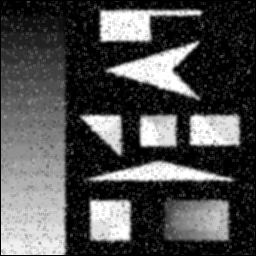




Problem 1: Here is the second filtered image, with kernel size 5X5.


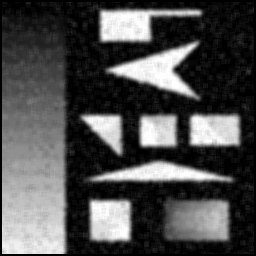

-1

In [ ]:
######## Problem 1: Apply two box filters. First of size 3X3 and second of size 5X5 ##################
########                      This is for 'image1.png                               ##################
size_of_box_kernel = 3
box_kernel = get_box_kernel(size_of_box_kernel)

image = get_image('/content/drive/MyDrive/COP4453 (Robot Vision)/Assignment1/images/image1.png')

# Here, we will apply the first filter to the input image
image_filtered = apply_filter(image, box_kernel)

# Display the first filtered image
print('Problem 1: Here is the first filtered image, with kernel size 3X3.')
cv2_imshow(image_filtered)
cv2.waitKey(0)

print('\n\n')

# Change the size of the box kernel to five and get a new filter kernel
size_of_box_kernel = 5
box_kernel = get_box_kernel(size_of_box_kernel)

# Here, we will apply the second filter to the input image
image_filtered = apply_filter(image, box_kernel)

# Display the second filtered image
print('Problem 1: Here is the second filtered image, with kernel size 5X5.')
cv2_imshow(image_filtered)
cv2.waitKey(0)

Problem 1: Here is the first filtered image, with kernel size 3X3.


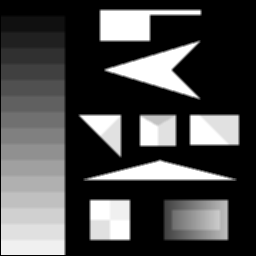




Problem 1: Here is the second filtered image, with kernel size 5X5.


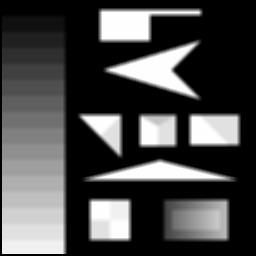

-1

In [ ]:
######## Problem 1: Apply two box filters. First of size 3X3 and second of size 5X5 ##################
########                      This is for 'image2.png'                              ##################
size_of_box_kernel = 3
box_kernel = get_box_kernel(size_of_box_kernel)

image = get_image('/content/drive/MyDrive/COP4453 (Robot Vision)/Assignment1/images/image2.png')

# Here, we will apply the first filter to the input image
image_filtered = apply_filter(image, box_kernel)

# Display the first filtered image
print('Problem 1: Here is the first filtered image, with kernel size 3X3.')
cv2_imshow(image_filtered)
cv2.waitKey(0)

print('\n\n')

# Change the size of the box kernel to five and get a new filter kernel
size_of_box_kernel = 5
box_kernel = get_box_kernel(size_of_box_kernel)

# Here, we will apply the second filter to the input image
image_filtered = apply_filter(image, box_kernel)

# Display the second filtered image
print('Problem 1: Here is the second filtered image, with kernel size 5X5.')
cv2_imshow(image_filtered)
cv2.waitKey(0)

Problem 2: image1.png with median filter of 3X3


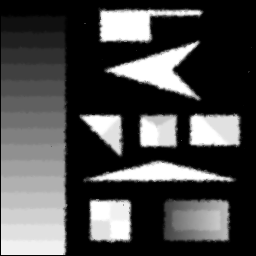




Problem 2: image1.png with median filter of 5X5


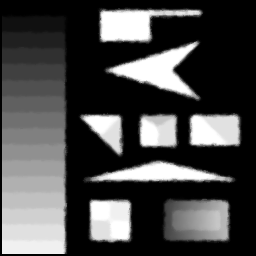




Problem 2: image1.png with median filter of 7X7


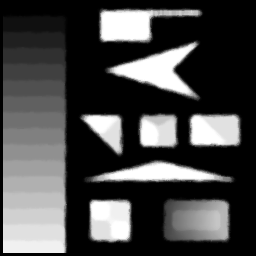

-1

In [ ]:
######## Problem 2: Apply three median filters. Size: 3X3, 5X5, and 7X7   ##################
########                     This is for 'image1.png'                     ##################

########### We first start off with a median kernel size of 3 ###############
median_kernel_size = 3

# Get the image we will use for median filtering
image = get_image('/content/drive/MyDrive/COP4453 (Robot Vision)/Assignment1/images/image1.png')

# Run the median filtering algorithm on the image
image_filtered = apply_filter_median(image, median_kernel_size)

# Show the final result of the algorithm on the image
print('Problem 2: image1.png with median filter of 3X3')
cv2_imshow(image_filtered)
cv2.waitKey(0)

print('\n\n')

########### Next, we use a median kernel size of 5 ###############
median_kernel_size = 5

# Perform the algorithm on the image
image_filtered = apply_filter_median(image, median_kernel_size)

# Show the final result of the algorithm on the image
print('Problem 2: image1.png with median filter of 5X5')
cv2_imshow(image_filtered)
cv2.waitKey(0)

print('\n\n')

########### Next, we use a median kernel size of 7 ###############
median_kernel_size = 7

# Perform the algorithm on the image
image_filtered = apply_filter_median(image, median_kernel_size)

# Show the final result of the algorithm on the image
print('Problem 2: image1.png with median filter of 7X7')
cv2_imshow(image_filtered)
cv2.waitKey(0)

Problem 2: image2.png with median filter of 3X3


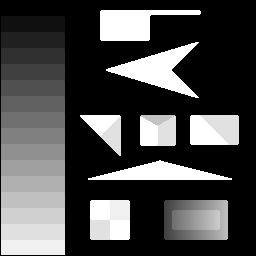




Problem 2: image2.png with median filter of 5X5


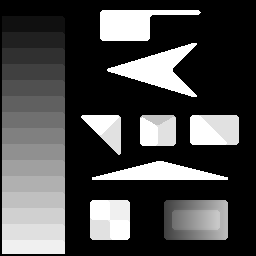




Problem 2: image2.png with median filter of 7X7


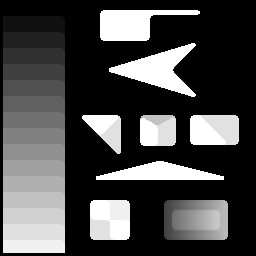

-1

In [ ]:
######## Problem 2: Apply three median filters. Size: 3X3, 5X5, and 7X7   ##################
########                     This is for 'image2.png'                     ##################

########### We first start off with a median kernel size of 3 ###############
median_kernel_size = 3

# Get the image that we are going to use median filtering
image = get_image('/content/drive/MyDrive/COP4453 (Robot Vision)/Assignment1/images/image2.png')
# Run the filtering algorithm on the image
image_filtered = apply_filter_median(image, median_kernel_size)

# Display the image after median filtering
print('Problem 2: image2.png with median filter of 3X3')
cv2_imshow(image_filtered)
cv2.waitKey(0)

print('\n\n')

########### Next, we use a median kernel size of 5 ###############
median_kernel_size = 5
# Run the filtering algorithm on the image
image_filtered = apply_filter_median(image, median_kernel_size)

# Display the image after median filtering
print('Problem 2: image2.png with median filter of 5X5')
cv2_imshow(image_filtered)
cv2.waitKey(0)

print('\n\n')

########### Next, we use a median kernel size of 7 ###############
median_kernel_size = 7
# Run the filtering algorithm on the image
image_filtered = apply_filter_median(image, median_kernel_size)

# Display the image after median filtering
print('Problem 2: image2.png with median filter of 7X7')
cv2_imshow(image_filtered)
cv2.waitKey(0)

Problem 3: image1.png, gauss filter, sigma = 3


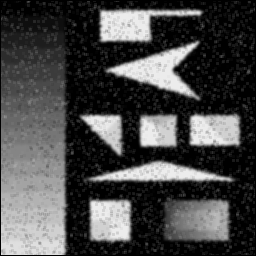




Problem 3: image1.png, gauss filter, sigma = 5


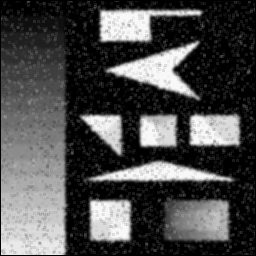




Problem 3: image1.png, gauss filter, sigma = 10


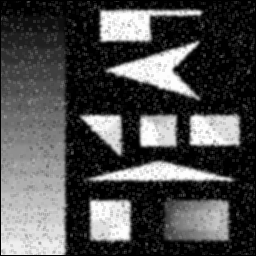

-1

In [ ]:
######## Problem 3: Apply Gaussian filter. Sigma: 3, 5, and 10  ##################
########             This is for 'image1.png'                   ##################

######## Gaussian filtering using sigma = 3 ########

# Create a gaussian filter with sigma = 3
gauss_kernel = create_gauss_filter(3, 3)

# Here we get 'image1.png' to be used for problem 3 and run the filter and
# convolution on it
image = get_image('/content/drive/MyDrive/COP4453 (Robot Vision)/Assignment1/images/image1.png')
image_filtered = apply_gauss_filter(image, gauss_kernel)
image_filtered_final =  image_filtered.astype(np.uint8)

# Display the result of the gaussian filter on the image with sigma = 3
print('Problem 3: image1.png, gauss filter, sigma = 3')
cv2_imshow(image_filtered_final)
cv2.waitKey(0)

print('\n\n')

######## Gaussian filtering using sigma = 5 ########

# Create a gaussian filter with sigma = 5
gauss_kernel = create_gauss_filter(3, 5)

# Here, we run the filter and convolution on 'image1.png' with sigma = 5
image_filtered = apply_gauss_filter(image, gauss_kernel)
image_filtered_final =  image_filtered.astype(np.uint8)

# Display the result of the gaussian filter on the image with sigma = 5
print('Problem 3: image1.png, gauss filter, sigma = 5')
cv2_imshow(image_filtered_final)
cv2.waitKey(0)

print('\n\n')

######## Gaussian filtering using sigma = 10 ########

# Create a gaussian filter with sigma = 10
gauss_kernel = create_gauss_filter(3, 10)

# Here, we run the filter and convolution on 'image1.png' with sigma = 10
image_filtered = apply_gauss_filter(image, gauss_kernel)
image_filtered_final =  image_filtered.astype(np.uint8)

# Display the result of the gaussian filter on the image with sigma = 10
print('Problem 3: image1.png, gauss filter, sigma = 10')
cv2_imshow(image_filtered_final)
cv2.waitKey(0)

Problem 3: image2.png, gauss filter, sigma = 3


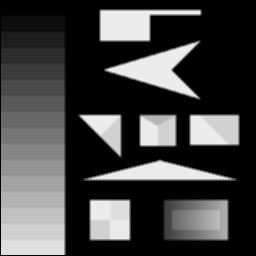




Problem 3: image2.png, gauss filter, sigma = 5


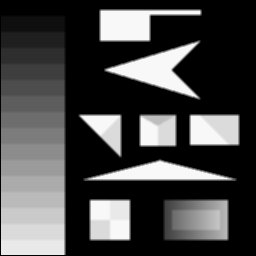




Problem 3: image2.png, gauss filter, sigma = 10


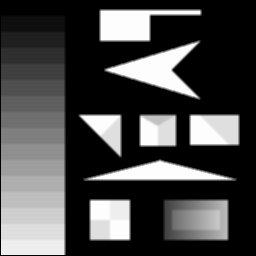

-1

In [ ]:
######## Problem 3: Apply Gaussian filter. Sigma: 3, 5, and 10  ##################
########             This is for 'image2.png'                   ##################

######## Gaussian filtering using sigma = 3 ########

# Create a gaussian filter with sigma = 3
gauss_kernel = create_gauss_filter(3, 3)

# Here we get 'image2.png' to be used for problem 3 and run the filter and
# convolution on it
image = get_image('/content/drive/MyDrive/COP4453 (Robot Vision)/Assignment1/images/image2.png')
image_filtered = apply_gauss_filter(image, gauss_kernel)
image_filtered_final =  image_filtered.astype(np.uint8)

# Display the result of the gaussian filter on the image with sigma = 3
print('Problem 3: image2.png, gauss filter, sigma = 3')
cv2_imshow(image_filtered_final)
cv2.waitKey(0)

print('\n\n')

######## Gaussian filtering using sigma = 5 ########

# Create a gaussian filter with sigma = 5
gauss_kernel = create_gauss_filter(3, 5)

# Here, we run the filter and convolution on 'image2.png' with sigma = 5
image_filtered = apply_gauss_filter(image, gauss_kernel)
image_filtered_final =  image_filtered.astype(np.uint8)

# Display the result of the gaussian filter on the image with sigma = 10
print('Problem 3: image2.png, gauss filter, sigma = 5')
cv2_imshow(image_filtered_final)
cv2.waitKey(0)

print('\n\n')

######## Gaussian filtering using sigma = 10 ########

# Create a gaussian filter with sigma = 10
gauss_kernel = create_gauss_filter(3, 10)

# Here, we run the filter and convolution on 'image2.png' with sigma = 10
image_filtered = apply_gauss_filter(image, gauss_kernel)
image_filtered_final =  image_filtered.astype(np.uint8)

# Display the result of the gaussian filter on the image with sigma = 10
print('Problem 3: image2.png, gauss filter, sigma = 10')
cv2_imshow(image_filtered_final)
cv2.waitKey(0)

Problem 4: image3.png after backward derivative with respect to x


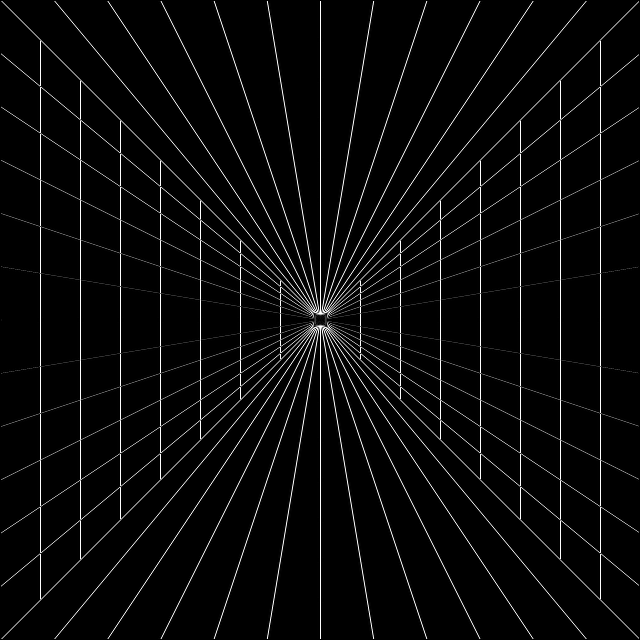




Problem 4: image3.png after backward derivative with respect to y


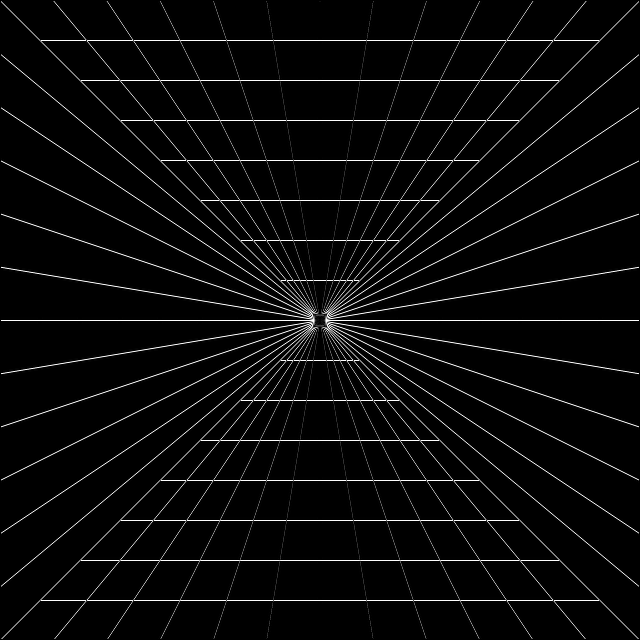




Problem 4: image3.png after backward derivative function applied


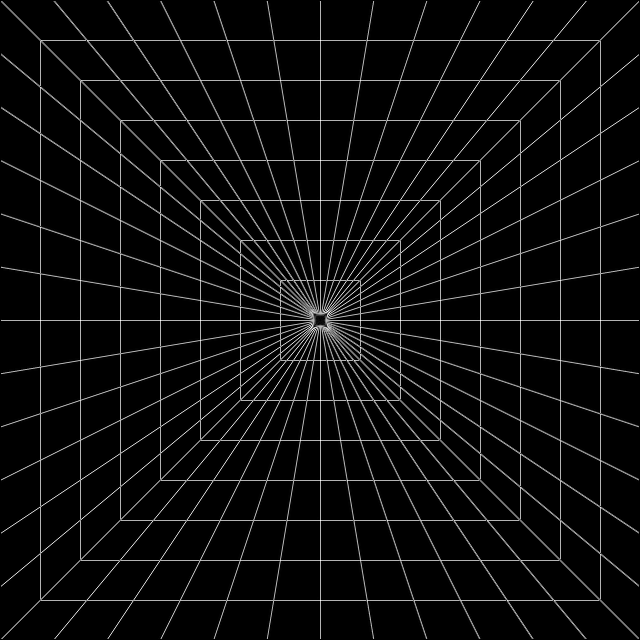




Problem 4: image3.png after forward derivative with respect to x


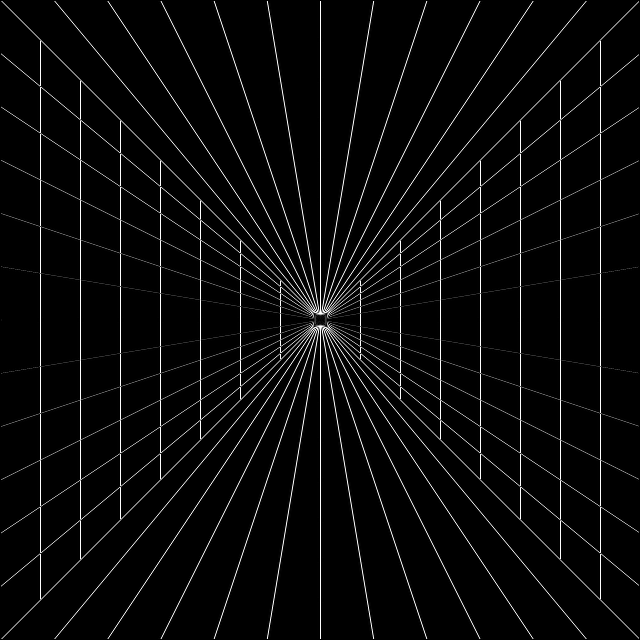




Problem 4: image3.png after forward derivative with respect to y


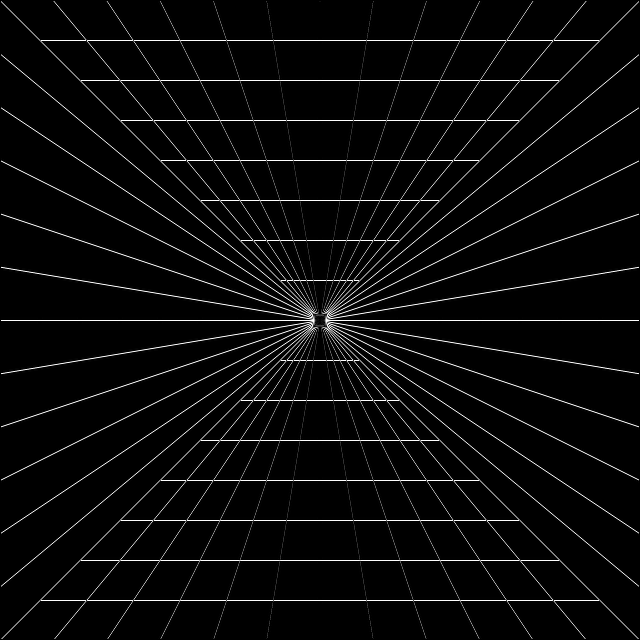




Problem 4: image3.png after forward derivative function applied


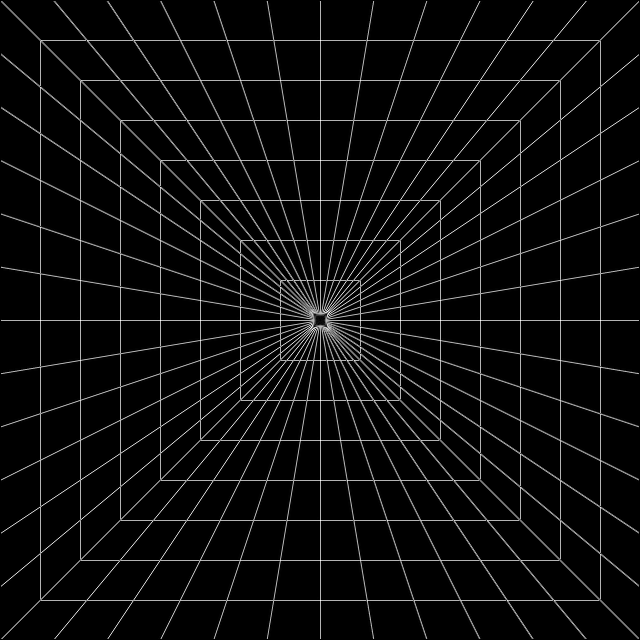




Problem 4: image3.png after central derivative with respect to x


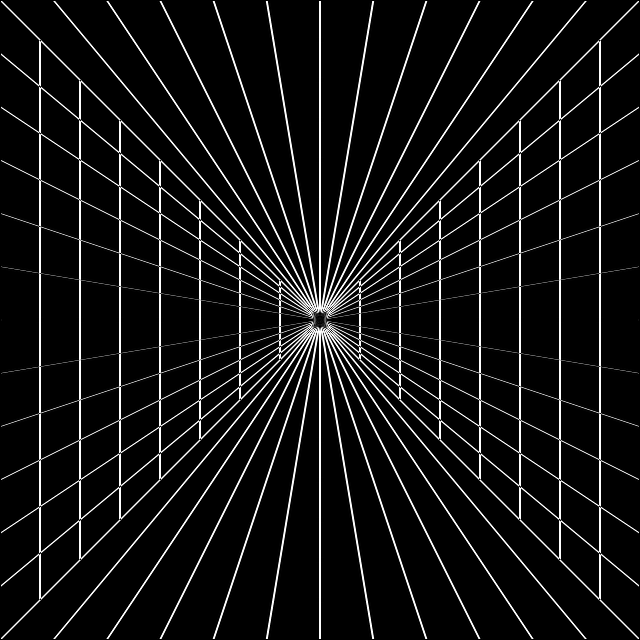




Problem 4: image3.png after central derivative with respect to y


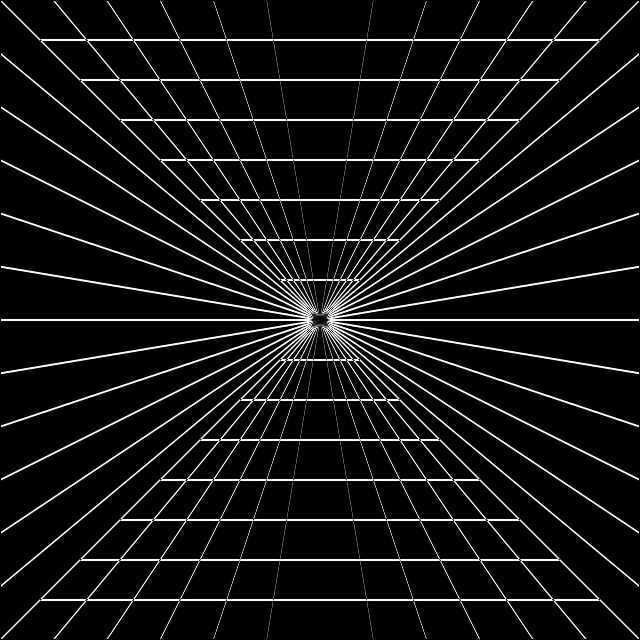




Problem 4: image3.png after central derivative function applied


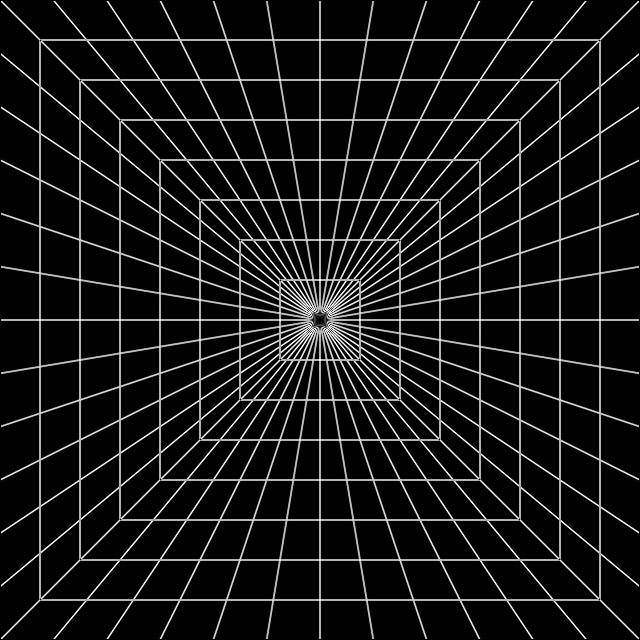

-1

In [ ]:
######## Problem 4: Derivative Operations. Forward, Backward, Central  ##################
########                   This is for 'image3.png'                    ##################

# Get the image to be used for the derivatives
image = get_image('/content/drive/MyDrive/COP4453 (Robot Vision)/Assignment1/images/image3.png')

######## Backward Derivative Operation ########

# Create the kernel needed for the backward derivative operation
backward_kernel = np.array([-1,1], np.float)

# Run the filter on the image, here we will use the 'apply_even_filter' function
# that takes into account the fact that we are using an even filter
image_filtered_x, image_filtered_y = apply_even_filter(image, backward_kernel)

# Get the magnitude of the two returned images
final_image = compute_gradient_magnitude(image_filtered_x, image_filtered_y)
final_image_display = final_image.astype(np.uint8)

# Adjust the image for displaying
image_filtered_x, image_filtered_y = adjust_derivative_images(image_filtered_x, image_filtered_y)

# Display the filtered image after derivative with respect to 'x'
print('Problem 4: image3.png after backward derivative with respect to x')
cv2_imshow(image_filtered_x)
cv2.waitKey(0)

print('\n\n')

# Display the filtered image after derivative with respect to 'y
print('Problem 4: image3.png after backward derivative with respect to y')
cv2_imshow(image_filtered_y)
cv2.waitKey(0)

print('\n\n')

# Display the final image
print('Problem 4: image3.png after backward derivative function applied')
cv2_imshow(final_image_display)
cv2.waitKey(0)

print('\n\n')

######## Forward Derivative Operation ########

# Create the kernel needed for the forward derivative operation
forward_kernel = np.array([1,-1], np.float)

# Run the filter on the image, here we will use the 'apply_even_filter' funciton
# that takes into account the fact that we are using an even kernel
image_filtered_x, image_filtered_y = apply_even_filter(image, forward_kernel)

# Get the magnitude of the two returned images
final_image = compute_gradient_magnitude(image_filtered_x, image_filtered_y)
final_image_display = final_image.astype(np.uint8)

# Adjust the image for displaying
image_filtered_x, image_filtered_y = adjust_derivative_images(image_filtered_x, image_filtered_y)

# Display the filtered image after derivative with respect to 'x'
print('Problem 4: image3.png after forward derivative with respect to x')
cv2_imshow(image_filtered_x)
cv2.waitKey(0)

print('\n\n')

# Display the filtered image after derivative with respect to 'y
print('Problem 4: image3.png after forward derivative with respect to y')
cv2_imshow(image_filtered_y)
cv2.waitKey(0)

print('\n\n')

# Display the final image
print('Problem 4: image3.png after forward derivative function applied')
cv2_imshow(final_image_display)
cv2.waitKey(0)

print('\n\n')

######## Central Derivative operation ########

# Create the kernel that is needed for the central derivative operation
central_kernel = np.array([-1,0,1], np.float)

# Run the filter on the image. NOTE: Here, we are using the normal function
# for the image, since the kernel is odd
image_filtered_x, image_filtered_y = apply_1D_filter(image, central_kernel)

# Get the magnitude of the two returned images
final_image = compute_gradient_magnitude(image_filtered_x, image_filtered_y)
final_image_display = final_image.astype(np.uint8)

# Adjust the images for display
image_filtered_x, image_filtered_y = adjust_derivative_images(image_filtered_x, image_filtered_y)

# Display the filtered image after derivative with respect to 'x'
print('Problem 4: image3.png after central derivative with respect to x')
cv2_imshow(image_filtered_x)
cv2.waitKey(0)

print('\n\n')

# Display the filtered image after derivative with respect to 'y
print('Problem 4: image3.png after central derivative with respect to y')
cv2_imshow(image_filtered_y)
cv2.waitKey(0)

print('\n\n')

# Display the final image
print('Problem 4: image3.png after central derivative function applied')
cv2_imshow(final_image_display)
cv2.waitKey(0)

Problem 5: image1.png after performing sobel filtering


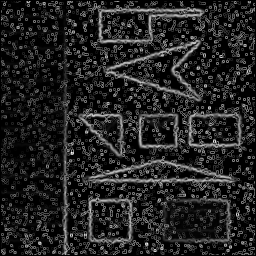




Problem 5: image2.png after performing sobel filtering


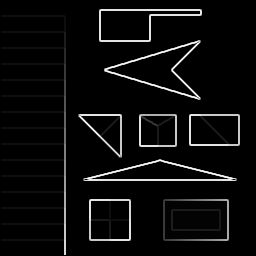

-1

In [ ]:
######## Problem 5: Perform Sobel Filtering. Kernel Size - 3X3  ##################
########       This is for image1.png and image2.png            ##################

############ Sobel Filtering: image1.png ############

# Here, we create the sobel filter, intially vertically and then get the image that
# we are going to use for this operation
sobel_kernel = np.array([[-1,0,1], [-2,0,2], [-1,0,1]])
image = get_image('/content/drive/MyDrive/COP4453 (Robot Vision)/Assignment1/images/image1.png')

# We want to get here the images using sobel filtering with respect to 'x' and 'y'
sobel_image_x = sobel_filter(image, sobel_kernel)
sobel_image_y = sobel_filter(image, np.rot90(sobel_kernel))

# Find the gradient magnitude of the images after performing sobel filtering
final_image = compute_gradient_magnitude(sobel_image_x, sobel_image_y)
final_image_display = final_image.astype(np.uint8)

# Display the final image after performing sobel filtering on 'image1.png'
print('Problem 5: image1.png after performing sobel filtering')
cv2_imshow(final_image_display)
cv2.waitKey(0)

############ Sobel Filtering: image2.png ############

# Here, we create the sobel filter, intially vertically and then get the image that
# we are going to use for this operation
sobel_kernel = np.array([[-1,0,1], [-2,0,2], [-1,0,1]])
image = get_image('/content/drive/MyDrive/COP4453 (Robot Vision)/Assignment1/images/image2.png')

# We want to get here the images using sobel filtering with respect to 'x' and 'y'
sobel_image_x = sobel_filter(image, sobel_kernel)
sobel_image_y = sobel_filter(image, np.rot90(sobel_kernel))

print('\n\n')

# Find the gradient magnitude of the images after performing sobel filtering
final_image = compute_gradient_magnitude(sobel_image_x, sobel_image_y)
final_image_display = final_image.astype(np.uint8)

# Display the final image after performing sobel filtering on 'image1.png'
print('Problem 5: image2.png after performing sobel filtering')
cv2_imshow(final_image_display)
cv2.waitKey(0)

Problem 6: image1.png guass in x direction sigma = 3


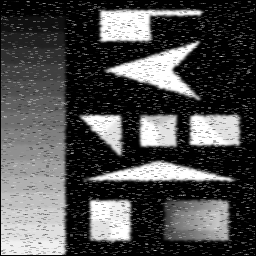




Problem 6: image1.png guass in y direction sigma = 3


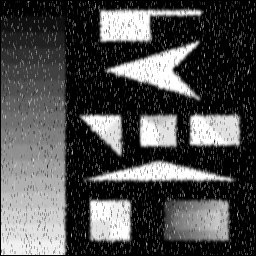




Problem 6: image1.png after fast gaussian filtering, sigma = 3


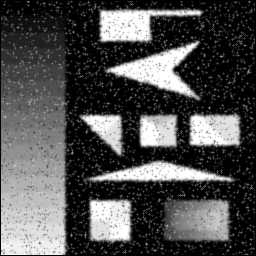




Problem 6: image1.png guass in x direction sigma = 5


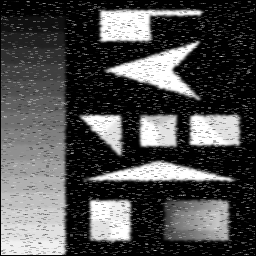




Problem 6: image1.png guass in y direction sigma = 5


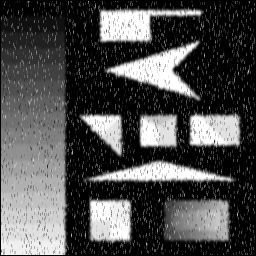




Problem 6: image1.png after fast gaussian filtering, sigma = 5


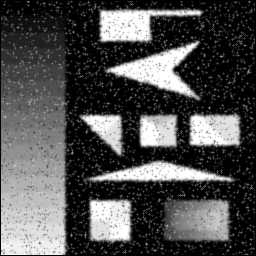




Problem 6: image1.png guass in x direction sigma = 10


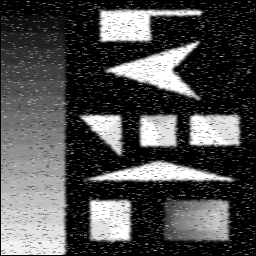




Problem 6: image1.png guass in y direction sigma = 10


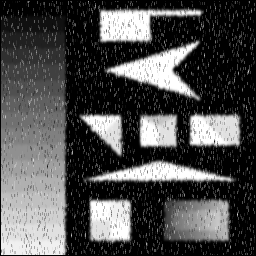




Problem 6: image1.png after fast gaussian filtering, sigma = 10


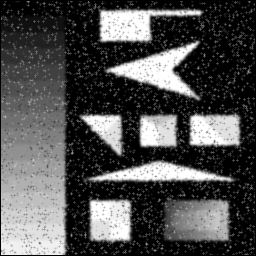

-1

In [ ]:
########   Problem 6: Fast Gaussian Filtering    ##################
########       This is for image1.png            ##################

# Here, get the image we are going to use as well as create the gauss kernel
image = get_image('/content/drive/MyDrive/COP4453 (Robot Vision)/Assignment1/images/image1.png')

############ Gauss kernel sigma = 3 ############

# Create the 1D gauss kernel with sigma 3
gauss_kernel = create_1Dgaussian_kernel(3, 3)

# Now, run the 1D gauss kernel on our image
output_image_x, output_image_y = apply_1D_filter(image, gauss_kernel)

# Compute the gradient magnitude of the two images
output_image = compute_gradient_magnitude(output_image_x, output_image_y)
output_image_final = output_image.astype(np.uint8)

# Adjust the images for display
output_image_x, output_image_y = adjust_derivative_images(output_image_x, output_image_y)

# Display the resulting image in x direction
print('Problem 6: image1.png guass in x direction sigma = 3')
cv2_imshow(output_image_x)
cv2.waitKey(0)

print('\n\n')

# Display the resulting image in y direction
print('Problem 6: image1.png guass in y direction sigma = 3')
cv2_imshow(output_image_y)
cv2.waitKey(0)

print('\n\n')

# Display the resulting image after computing the gradient magnitude
print('Problem 6: image1.png after fast gaussian filtering, sigma = 3')
cv2_imshow(output_image_final)
cv2.waitKey(0)

print('\n\n')

############ Gauss kernel sigma = 5 ############

# Here, create a new gauss kernel with sigam = 5
gauss_kernel = create_1Dgaussian_kernel(3, 5)

# Now, run the 1D gauss kernel on our image
output_image_x, output_image_y = apply_1D_filter(image, gauss_kernel)

# Compute the gradient magnitude of the two images
output_image = compute_gradient_magnitude(output_image_x, output_image_y)
ouput_image_final = output_image.astype(np.uint8)

# Adjust the images for display
output_image_x, output_image_y = adjust_derivative_images(output_image_x, output_image_y)

# Display the resulting image
print('Problem 6: image1.png guass in x direction sigma = 5')
cv2_imshow(output_image_x)
cv2.waitKey(0)

print('\n\n')

# Display the resulting image
print('Problem 6: image1.png guass in y direction sigma = 5')
cv2_imshow(output_image_y)
cv2.waitKey(0)

print('\n\n')

# Display the resulting image after computing the gradient magnitude
print('Problem 6: image1.png after fast gaussian filtering, sigma = 5')
cv2_imshow(output_image_final)
cv2.waitKey(0)

print('\n\n')

############ Gauss kernel sigma = 10 ############

# Here, create a new gauss kernel with sigam = 10
gauss_kernel = create_1Dgaussian_kernel(3, 10)

# Now, run the 1D gauss kernel on our image
output_image_x, output_image_y = apply_1D_filter(image, gauss_kernel)

# Compute the gradient magnitude of both images
output_image = compute_gradient_magnitude(output_image_x, output_image_y)
output_image_final = output_image.astype(np.uint8)

# Adjust the images for display
output_image_x, output_image_y = adjust_derivative_images(output_image_x, output_image_y)

# Display the resulting image
print('Problem 6: image1.png guass in x direction sigma = 10')
cv2_imshow(output_image_x)
cv2.waitKey(0)

print('\n\n')

# Display the resulting image
print('Problem 6: image1.png guass in y direction sigma = 10')
cv2_imshow(output_image_y)
cv2.waitKey(0)

print('\n\n')

# Display the resulting image
print('Problem 6: image1.png after fast gaussian filtering, sigma = 10')
cv2_imshow(output_image_final)
cv2.waitKey(0)

Problem 6: image2.png guass in x direction sigma = 3


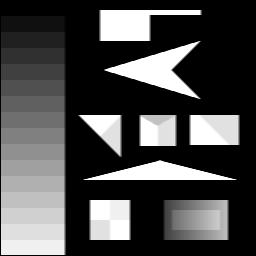




Problem 6: image2.png guass in y direction sigma = 3


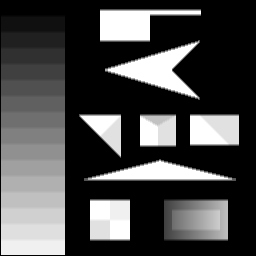




Problem 6: image2.png after fast gaussian filtering, sigma = 3


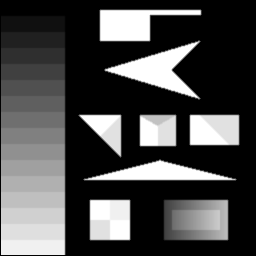




Problem 6: image2.png guass in x direction sigma = 5


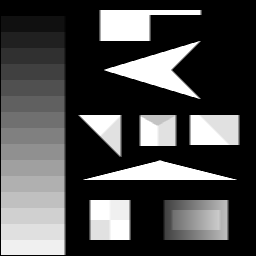




Problem 6: image2.png guass in y direction sigma = 5


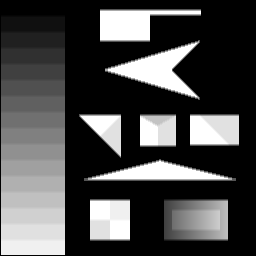




Problem 6: image2.png after fast gaussian filtering, sigma = 3


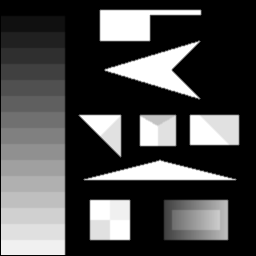




Problem 6: image2.png guass in x direction sigma = 10


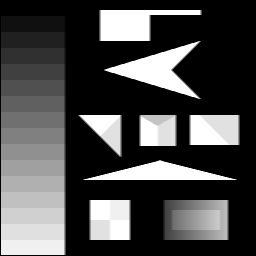




Problem 6: image2.png guass in y direction sigma = 10


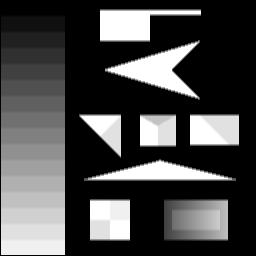




Problem 6: image1.png after fast gaussian filtering, sigma = 10


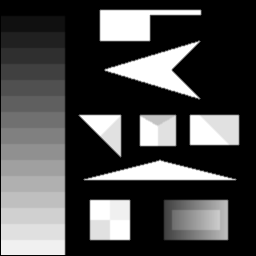

-1

In [ ]:
########   Problem 6: Fast Gaussian Filtering    ##################
########       This is for image2.png            ##################

# Here, get the image we are going to use as well as create the gauss kernel
image = get_image('/content/drive/MyDrive/COP4453 (Robot Vision)/Assignment1/images/image2.png')

############ Gauss kernel sigma = 3 ############

# Create the 1D gauss kernel with sigma = 3
gauss_kernel = create_1Dgaussian_kernel(3, 3)

# Now, run the 1D gauss kernel on our image
output_image_x, output_image_y = apply_1D_filter(image, gauss_kernel)

# Compute the gradient magnitude of both images
output_image = compute_gradient_magnitude(output_image_x, output_image_y)
output_image_final = output_image.astype(np.uint8)

# Adjust the images for display
output_image_x, output_image_y = adjust_derivative_images(output_image_x, output_image_y)

# Display the resulting image in x direction
print('Problem 6: image2.png guass in x direction sigma = 3')
cv2_imshow(output_image_x)
cv2.waitKey(0)

print('\n\n')

# Display the resulting image in y direction
print('Problem 6: image2.png guass in y direction sigma = 3')
cv2_imshow(output_image_y)
cv2.waitKey(0)

print('\n\n')

# Display the resulting image after computing the gradient magnitude
print('Problem 6: image2.png after fast gaussian filtering, sigma = 3')
cv2_imshow(output_image_final)
cv2.waitKey(0)

print('\n\n')

############ Gauss kernel sigma = 5 ############

# Here, create a new gauss kernel with sigam = 5
gauss_kernel = create_1Dgaussian_kernel(3, 5)

# Now, run the 1D gauss kernel on our image
output_image_x, output_image_y = apply_1D_filter(image, gauss_kernel)

# Compute the gradient magnitude of both images
output_image = compute_gradient_magnitude(output_image_x, output_image_y)
output_image_final = output_image.astype(np.uint8)

# Adjust the images for display
output_image_x, output_image_y = adjust_derivative_images(output_image_x, output_image_y)

# Display the resulting image
print('Problem 6: image2.png guass in x direction sigma = 5')
cv2_imshow(output_image_x)
cv2.waitKey(0)

print('\n\n')

# Display the resulting image
print('Problem 6: image2.png guass in y direction sigma = 5')
cv2_imshow(output_image_y)
cv2.waitKey(0)

print('\n\n')

# Display the resulting image after computing the gradient magnitude
print('Problem 6: image2.png after fast gaussian filtering, sigma = 3')
cv2_imshow(output_image_final)
cv2.waitKey(0)

print('\n\n')

############ Gauss kernel sigma = 10 ############

# Here, create a new gauss kernel with sigam = 10
gauss_kernel = create_1Dgaussian_kernel(3, 10)

# Now, run the 1D gauss kernel on our image
output_image_x, output_image_y = apply_1D_filter(image, gauss_kernel)

# Compute the gradient magnitude of both images
output_image = compute_gradient_magnitude(output_image_x, output_image_y)
output_image_final = output_image.astype(np.uint8)

# Adjust the images for display
output_image_x, output_image_y = adjust_derivative_images(output_image_x, output_image_y)

# Display the resulting image
print('Problem 6: image2.png guass in x direction sigma = 10')
cv2_imshow(output_image_x)
cv2.waitKey(0)

print('\n\n')

# Display the resulting image
print('Problem 6: image2.png guass in y direction sigma = 10')
cv2_imshow(output_image_y)
cv2.waitKey(0)

print('\n\n')

# Display the resulting image
print('Problem 6: image1.png after fast gaussian filtering, sigma = 10')
cv2_imshow(output_image_final)
cv2.waitKey(0)

Histogram of image4.png with 256 bins


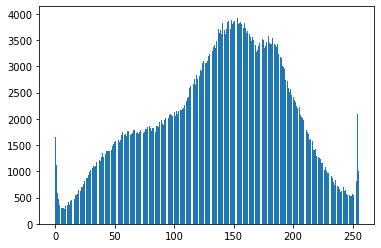




Histogram of image4.png with 128 bins


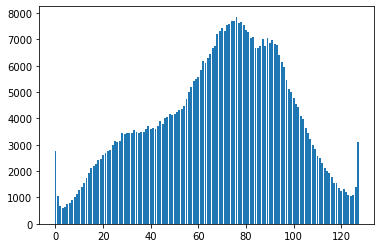




Histogram of image4.png with 64 bins


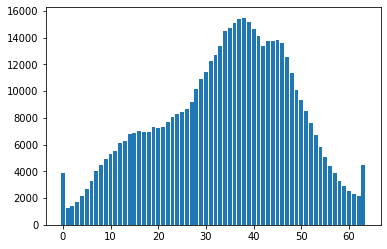

In [ ]:
########   Problem 7: Create a historgram   ##################
########       This is for image4.png       ##################

image = get_image('/content/drive/MyDrive/COP4453 (Robot Vision)/Assignment1/images/image4.png')

# Create and plot the histogram for image4.png with 256 bins
print('Histogram of image4.png with 256 bins')
hist = plot_histogram(image, 256)

print('\n\n')

# Create and plot the histogram for image4.png with 128 bins
print('Histogram of image4.png with 128 bins')
hist = plot_histogram(image, 128)

print('\n\n')

# Create and plot the histogram for image4.png with 64 bins
print('Histogram of image4.png with 64 bins')
hist = plot_histogram(image, 64)

Final image after canny edge detection algorithm. Sigma = 3


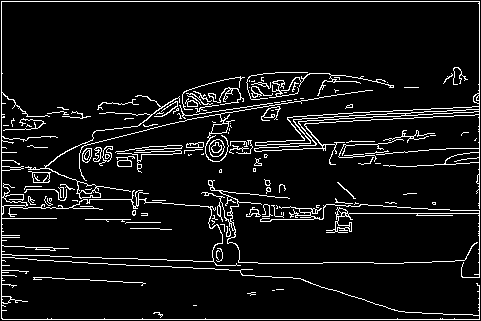




Final image after canny edge detection algorithm. Sigma = 5


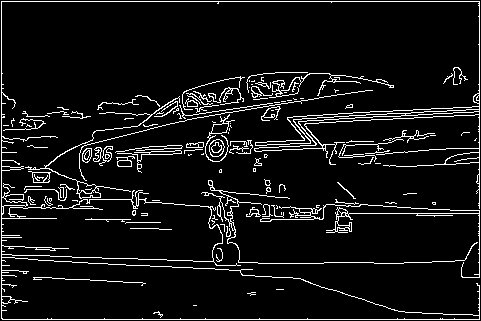




Final image after canny edge detection algorithm. Sigma = 10


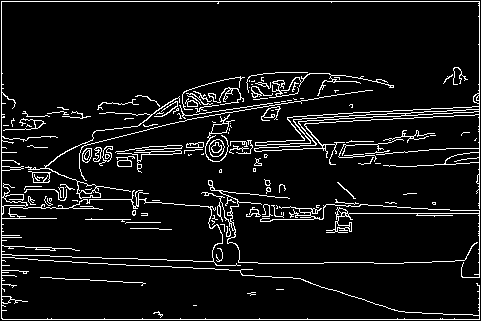

-1

In [ ]:
##################   Problem 8: Canny Edge Detection   ##################
##################      This is for canny1.jpg        ##################

# Retrieve the image that we are going to perform the canny edge detection algorithm on
image = get_image('/content/drive/MyDrive/COP4453 (Robot Vision)/Assignment1/images/canny1.jpg')

##################    Gauss kernel, sigma = 3    ##################

# Create the 1st gaussian kernel that we are going to use for the algorithm
gauss_kernel = create_1Dgaussian_kernel(3, 3)

# Get the images in the 'x' and 'y' direction with gauss kernel
img_x, img_y = apply_1D_filter(image, gauss_kernel)

# # Get the final filtered image after gaussian kernel and and create the sobel filter
# # that will be used for the gradient calculations
filtered_image = compute_gradient_magnitude(img_x, img_y)
sobel_kernel = np.array([[-1,0,1], [-2,0,2], [-1,0,1]])

# Here, we get the derivatives with respect to 'x' and 'y' of the filtered image
derivative_x = sobel_filter(filtered_image, sobel_kernel)
derivative_y = sobel_filter(filtered_image, np.rot90(sobel_kernel))

# Now, we calculate the gradient magnitude as well as the gradient orientation
gradient_magnitude = compute_gradient_magnitude(derivative_x, derivative_y)
gradient_orientation = np.arctan2(derivative_y, derivative_x)

# Next, we will apply the non-max supression algoriithm to our image
non_max_image = non_max_supression(gradient_magnitude, gradient_orientation)

# The next step we will apply the hysteresis threshold algorithm. In my implementation
# I break this up into two steps. First, threshold and then hysteresis
result, weak, strong = threshold_canny(non_max_image, 0.09, 0.11)

# Finally, we get the final image after performing hysteresis
final_image = hysteresis(result, weak, strong)
final_image_display = final_image.astype(np.uint8)

# Display the final image with our specified sigma
print('Final image after canny edge detection algorithm. Sigma = 3')
cv2_imshow(final_image_display)
cv2.waitKey(0)

print('\n\n')

##################    Gauss kernel, sigma = 5    ##################

# Create the 1st gaussian kernel that we are going to use for the algorithm
gauss_kernel = create_1Dgaussian_kernel(3, 5)

# Get the images in the 'x' and 'y' direction with gauss kernel
img_x, img_y = apply_1D_filter(image, gauss_kernel)

# Get the final filtered image after gaussian kernel and and create the sobel filter
# that will be used for the gradient calculations
filtered_image = compute_gradient_magnitude(img_x, img_y)
sobel_kernel = np.array([[-1,0,1], [-2,0,2], [-1,0,1]])

# Here, we get the derivatives with respect to 'x' and 'y' of the filtered image
derivative_x = sobel_filter(filtered_image, sobel_kernel)
derivative_y = sobel_filter(filtered_image, np.rot90(sobel_kernel))

# Now, we calculate the gradient magnitude as well as the gradient orientation
gradient_magnitude = compute_gradient_magnitude(derivative_x, derivative_y)
gradient_orientation = np.arctan2(derivative_y, derivative_x)

# Next, we will apply the non-max supression algoriithm to our image
non_max_image = non_max_supression(gradient_magnitude, gradient_orientation)

# The next step we will apply the hysteresis threshold algorithm. In my implementation
# I break this up into two steps. First, threshold and then hysteresis
result, weak, strong = threshold_canny(non_max_image, 0.07, 0.11)

# Finally, we get the final image after performing hysteresis
final_image = hysteresis(result, weak, strong)
final_image_display = final_image.astype(np.uint8)

# Display the final image with our specified sigma
print('Final image after canny edge detection algorithm. Sigma = 5')
cv2_imshow(final_image_display)
cv2.waitKey(0)

print('\n\n')

##################    Gauss kernel, sigma = 10    ##################

# Create the 1st gaussian kernel that we are going to use for the algorithm
gauss_kernel = create_1Dgaussian_kernel(3, 10)

# Get the images in the 'x' and 'y' direction with gauss kernel
img_x, img_y = apply_1D_filter(image, gauss_kernel)

# Get the final filtered image after gaussian kernel and and create the sobel filter
# that will be used for the gradient calculations
filtered_image = compute_gradient_magnitude(img_x, img_y)
sobel_kernel = np.array([[-1,0,1], [-2,0,2], [-1,0,1]])

# Here, we get the derivatives with respect to 'x' and 'y' of the filtered image
derivative_x = sobel_filter(filtered_image, sobel_kernel)
derivative_y = sobel_filter(filtered_image, np.rot90(sobel_kernel))

# Now, we calculate the gradient magnitude as well as the gradient orientation
gradient_magnitude = compute_gradient_magnitude(derivative_x, derivative_y)
gradient_orientation = np.arctan2(derivative_y, derivative_x)

# Next, we will apply the non-max supression algoriithm to our image
non_max_image = non_max_supression(gradient_magnitude, gradient_orientation)

# The next step we will apply the hysteresis threshold algorithm. In my implementation
# I break this up into two steps. First, threshold and then hysteresis
result, weak, strong = threshold_canny(non_max_image, 0.07, 0.11)

# Finally, we get the final image after performing hysteresis
final_image = hysteresis(result, weak, strong)
final_image_display = final_image.astype(np.uint8)

# Display the final image with our specified sigma
print('Final image after canny edge detection algorithm. Sigma = 10')
cv2_imshow(final_image_display)
cv2.waitKey(0)

Final image after canny edge detection algorithm. Sigma = 3


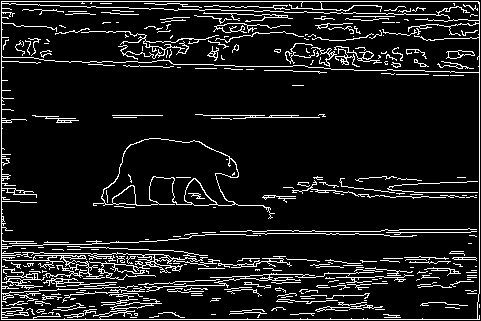




Final image after canny edge detection algorithm. Sigma = 5


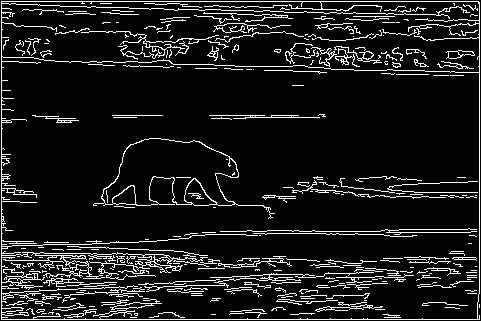




Final image after canny edge detection algorithm. Sigma = 10


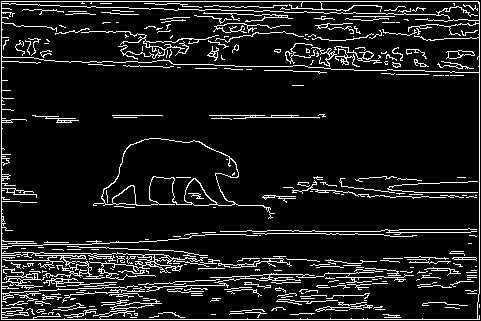

-1

In [ ]:
########   Problem 8: Canny Edge Detection   ##################
########       This is for canny2.jpg        ##################

image = get_image('/content/drive/MyDrive/COP4453 (Robot Vision)/Assignment1/images/canny2.jpg')

##################    Gauss kernel, sigma = 3    ##################

# Create the 1st gaussian kernel that we are going to use for the algorithm
gauss_kernel = create_1Dgaussian_kernel(3, 3)

# Get the images in the 'x' and 'y' direction with gauss kernel
img_x, img_y = apply_1D_filter(image, gauss_kernel)

# Get the final filtered image after gaussian kernel and and create the sobel filter
# that will be used for the gradient calculations
filtered_image = compute_gradient_magnitude(img_x, img_y)
sobel_kernel = np.array([[-1,0,1], [-2,0,2], [-1,0,1]])

# Here, we get the derivatives with respect to 'x' and 'y' of the filtered image
derivative_x = sobel_filter(filtered_image, sobel_kernel)
derivative_y = sobel_filter(filtered_image, np.rot90(sobel_kernel))

# Now, we calculate the gradient magnitude as well as the gradient orientation
gradient_magnitude = compute_gradient_magnitude(derivative_x, derivative_y)
gradient_orientation = np.arctan2(derivative_y, derivative_x)

# Next, we will apply the non-max supression algoriithm to our image
non_max_image = non_max_supression(gradient_magnitude, gradient_orientation)

# The next step we will apply the hysteresis threshold algorithm. In my implementation
# I break this up into two steps. First, threshold and then hysteresis
result, weak, strong = threshold_canny(non_max_image)

# Finally, we get the final image after performing hysteresis
final_image = hysteresis(result, weak, strong)

# Display the final image with our specified sigma
print('Final image after canny edge detection algorithm. Sigma = 3')
cv2_imshow(final_image)
cv2.waitKey(0)

print('\n\n')

##################    Gauss kernel, sigma = 5    ##################

# Create the 1st gaussian kernel that we are going to use for the algorithm
gauss_kernel = create_1Dgaussian_kernel(3, 5)

# Get the images in the 'x' and 'y' direction with gauss kernel
img_x, img_y = apply_1D_filter(image, gauss_kernel)

# Get the final filtered image after gaussian kernel and and create the sobel filter
# that will be used for the gradient calculations
filtered_image = compute_gradient_magnitude(img_x, img_y)
sobel_kernel = np.array([[-1,0,1], [-2,0,2], [-1,0,1]])

# Here, we get the derivatives with respect to 'x' and 'y' of the filtered image
derivative_x = sobel_filter(filtered_image, sobel_kernel)
derivative_y = sobel_filter(filtered_image, np.rot90(sobel_kernel))

# Now, we calculate the gradient magnitude as well as the gradient orientation
gradient_magnitude = compute_gradient_magnitude(derivative_x, derivative_y)
gradient_orientation = np.arctan2(derivative_y, derivative_x)

# Next, we will apply the non-max supression algoriithm to our image
non_max_image = non_max_supression(gradient_magnitude, gradient_orientation)

# The next step we will apply the hysteresis threshold algorithm. In my implementation
# I break this up into two steps. First, threshold and then hysteresis
result, weak, strong = threshold_canny(non_max_image)

# Finally, we get the final image after performing hysteresis
final_image = hysteresis(result, weak, strong)

# Display the final image with our specified sigma
print('Final image after canny edge detection algorithm. Sigma = 5')
cv2_imshow(final_image)
cv2.waitKey(0)

print('\n\n')

##################    Gauss kernel, sigma = 10    ##################

# Create the 1st gaussian kernel that we are going to use for the algorithm
gauss_kernel = create_1Dgaussian_kernel(3, 10)

# Get the images in the 'x' and 'y' direction with gauss kernel
img_x, img_y = apply_1D_filter(image, gauss_kernel)

# Get the final filtered image after gaussian kernel and and create the sobel filter
# that will be used for the gradient calculations
filtered_image = compute_gradient_magnitude(img_x, img_y)
sobel_kernel = np.array([[-1,0,1], [-2,0,2], [-1,0,1]])

# Here, we get the derivatives with respect to 'x' and 'y' of the filtered image
derivative_x = sobel_filter(filtered_image, sobel_kernel)
derivative_y = sobel_filter(filtered_image, np.rot90(sobel_kernel))

# Now, we calculate the gradient magnitude as well as the gradient orientation
gradient_magnitude = compute_gradient_magnitude(derivative_x, derivative_y)
gradient_orientation = np.arctan2(derivative_y, derivative_x)

# Next, we will apply the non-max supression algoriithm to our image
non_max_image = non_max_supression(gradient_magnitude, gradient_orientation)

# The next step we will apply the hysteresis threshold algorithm. In my implementation
# I break this up into two steps. First, threshold and then hysteresis
result, weak, strong = threshold_canny(non_max_image)

# Finally, we get the final image after performing hysteresis
final_image = hysteresis(result, weak, strong)

# Display the final image with our specified sigma
print('Final image after canny edge detection algorithm. Sigma = 10')
cv2_imshow(final_image)
cv2.waitKey(0)

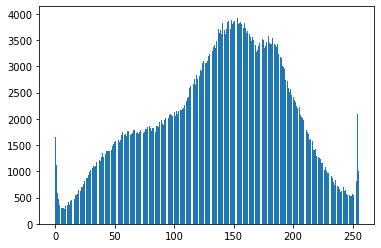

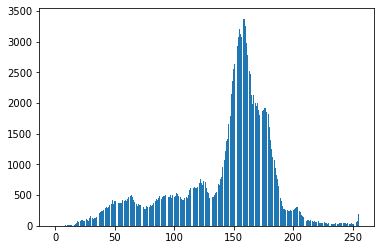

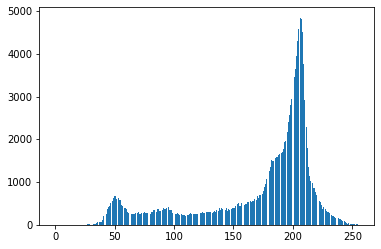




image4.png: threshold = 175


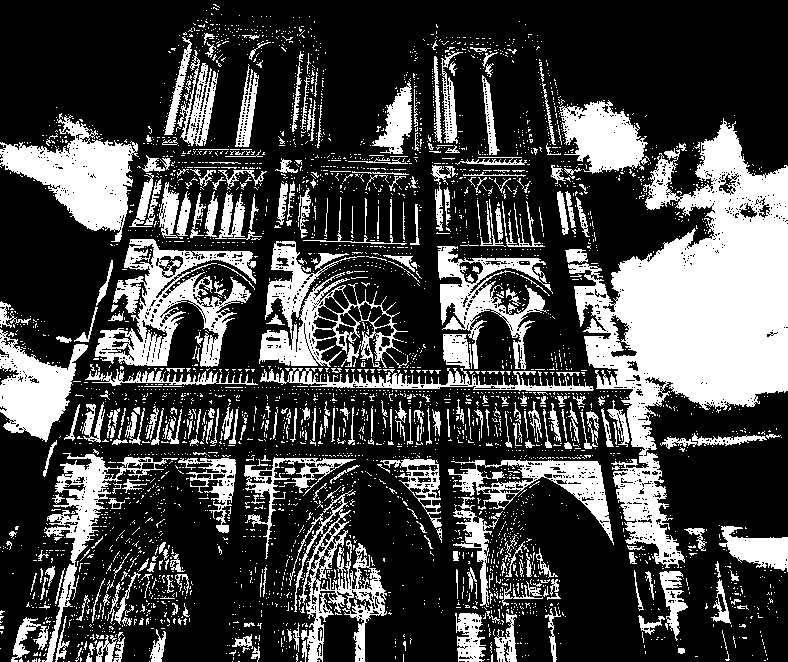




image4.png: threshold = 60


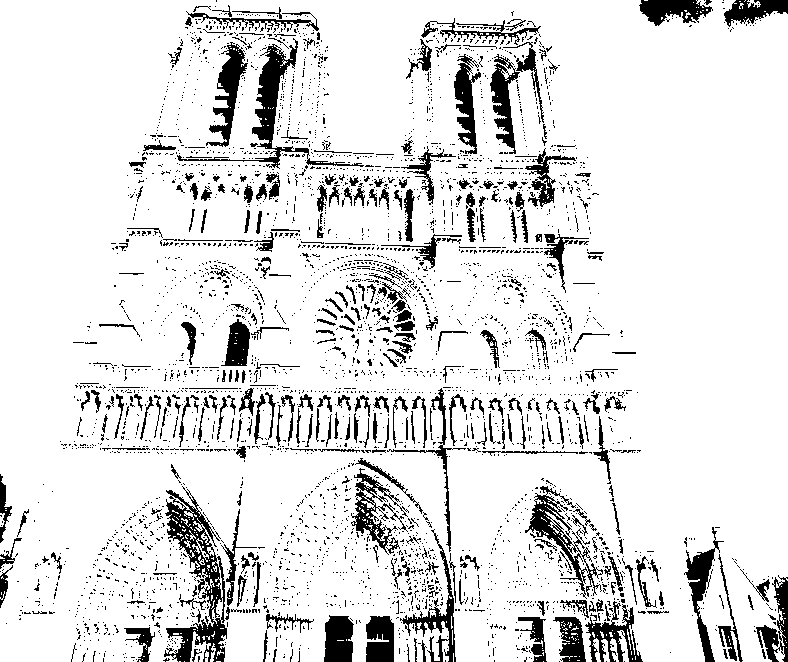




image4.png: threshold = 200


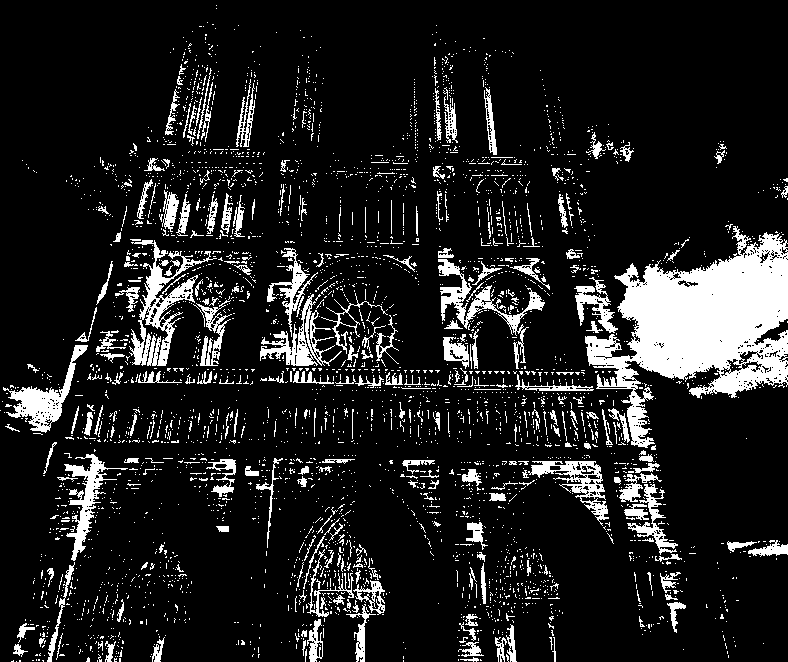




canny1.png: threshold = 75


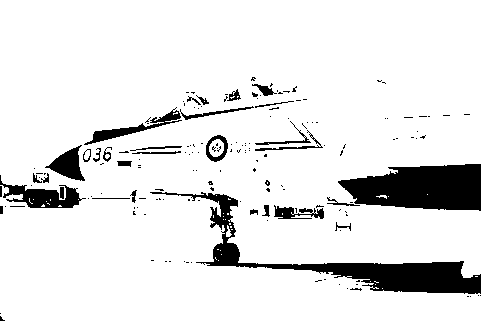




canny1.png: threshold = 140


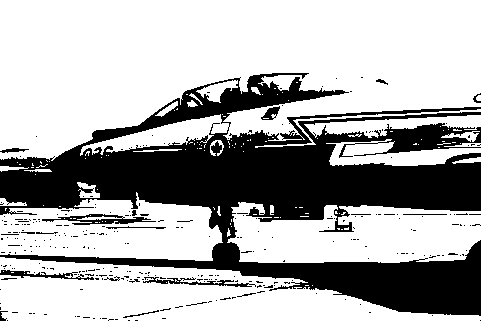




canny1.png: threshold = 170


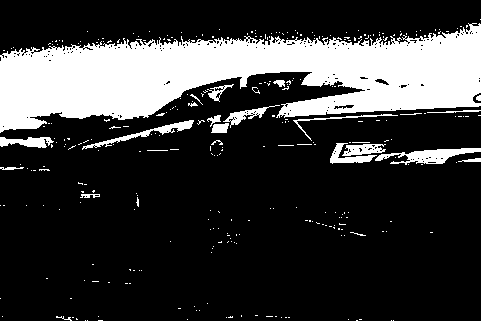




picture1.png: threshold = 100


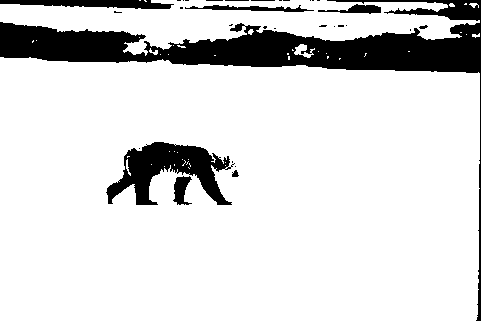




picture1.png: threshold = 200


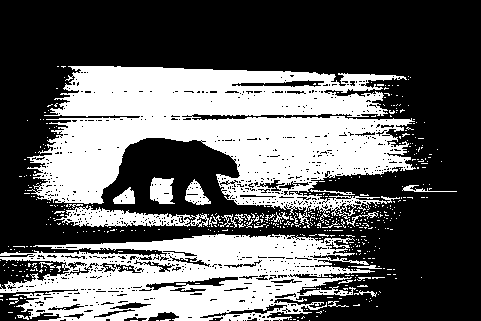




picture1.png: threshold = 150


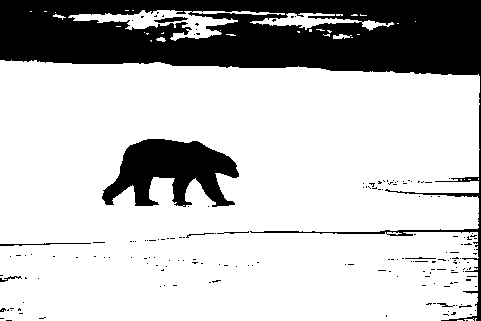

-1

In [ ]:
########                Problem 9: Image Segmentation                    ##################
########       1st task: Implement a simple binarization algorithm       ##################

# Get all of the images that we are going to need for problem 9
image1 = get_image('/content/drive/MyDrive/COP4453 (Robot Vision)/Assignment1/images/image4.png')
image2 = get_image('/content/drive/MyDrive/COP4453 (Robot Vision)/Assignment1/images/canny1.jpg')
image3 = get_image('/content/drive/MyDrive/COP4453 (Robot Vision)/Assignment1/images/picture1.png')

# First, we will create and plot the histogram for all three images
hist = plot_histogram(image1, 256)
hist = plot_histogram(image2, 256)
hist = plot_histogram(image3, 256)

print('\n\n')

##################    Binarization for image4.png   ##################

# Initialize our values for the first binarization
threshold_num = 175
maxval = 255

# Perform binarization on image4.png and display it
print('image4.png: threshold = 175')
result1 = (image1 > threshold_num) * maxval
cv2_imshow(result1)
cv2.waitKey(0)

print('\n\n')

# Initialize our next threshold
threshold_num = 60

# Perform binarization on image4.png and display it
print('image4.png: threshold = 60')
result1 = (image1 > threshold_num) * maxval
cv2_imshow(result1)
cv2.waitKey(0)

print('\n\n')

# Initialize our next threshold
threshold_num = 200

# Perform binarization on image4.png and display it
print('image4.png: threshold = 200')
result1 = (image1 > threshold_num) * maxval
cv2_imshow(result1)
cv2.waitKey(0)

print('\n\n')

##################    Binarization for canny1.jpg   ##################

# Initialize our next threshold
threshold_num = 75

# Perform binarization on canny1.jpg and display
print('canny1.png: threshold = 75')
result2 = (image2 > threshold_num) * maxval
cv2_imshow(result2)
cv2.waitKey(0)

print('\n\n')

# Initialize our next threshold
threshold_num = 140

# Perform binarization on canny1.jpg and display
print('canny1.png: threshold = 140')
result2 = (image2 > threshold_num) * maxval
cv2_imshow(result2)
cv2.waitKey(0)

print('\n\n')

# Initialize our next threshold
threshold_num = 170

# Perform binarization on canny1.png and display
print('canny1.png: threshold = 170')
result2 = (image2 > threshold_num) * maxval
cv2_imshow(result2)
cv2.waitKey(0)

print('\n\n')

##################    Binarization for picture1.png   ##################

# Initialize our next threshold
threshold_num = 100

# Perform binarization on picture1.png and display
print('picture1.png: threshold = 100')
result3 = (image3 > threshold_num) * maxval
cv2_imshow(result3)
cv2.waitKey(0)

print('\n\n')

# Initialize our next threshold
threshold_num = 200

# Perform binarization on picture1.png and display
print('picture1.png: threshold = 200')
result3 = (image3 > threshold_num) * maxval
cv2_imshow(result3)
cv2.waitKey(0)

print('\n\n')

# Initialize our next threshold
threshold_num = 150

# Perform binarizaiton on picture1.png and display
print('picture1.png: threshold = 150')
result3 = (image3 > threshold_num) * maxval
cv2_imshow(result3)
cv2.waitKey(0)

Histogram for image4.png


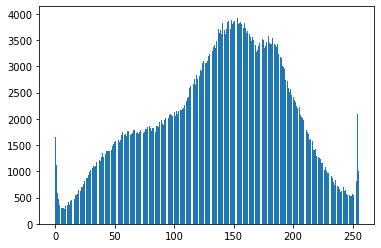




image4.png after Otsu thresholding algorithm


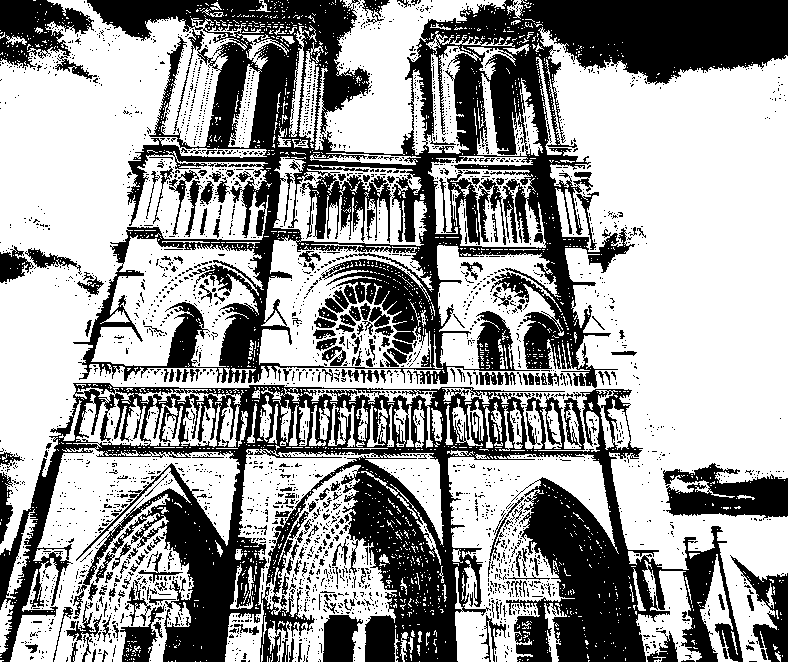




Histogram for canny1.jpg


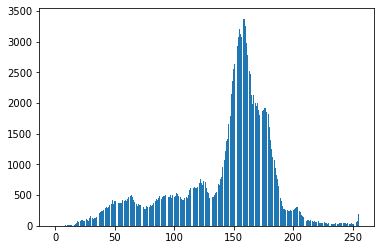

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars


canny1.jpg after Otsu thresholding algorithm


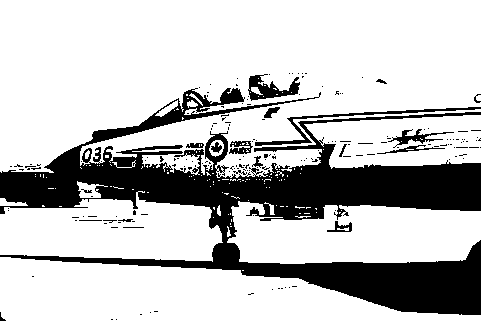




Histogram for picture1.png


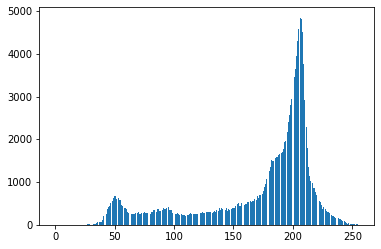




picture1.png after Otsu thresholding algorithm


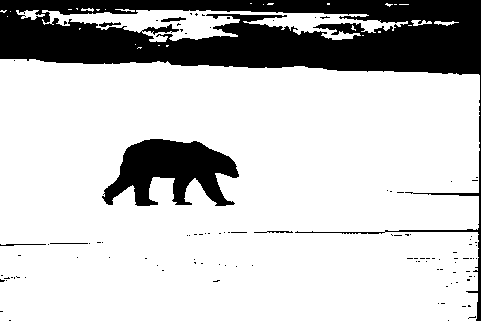

-1

In [ ]:
########                Problem 9: Image Segmentation                ##################
########       2nd task: Implement Otsu thresholding algorithm       ##################

########### First image: image4.png ###########

# Retrive the image that we are going to use for the Otsu thresholding algorithm
image = get_image('/content/drive/MyDrive/COP4453 (Robot Vision)/Assignment1/images/image4.png')

# First we want to create and plot the histogram for image4.png
print('Histogram for image4.png')
histogram = plot_histogram(image, 256)

print('\n\n')

# Here, I create an empy dict that will hold a list of our thresholds
threshold_list = {}

# This will be the main driving force of our Otsu thresholding algorithm
threshold_list = threshold_otsu(histogram, threshold_list)

# Now, lets find the optimal threshold for our image
optimal_threshold = get_optimal_threshold(threshold_list)

# Lastly, generate the final image from our Otsu thresholding algorithm. Then
# prepare it for display
otsu_image = regenerate_img(image, optimal_threshold)
otsu_final_image = otsu_image.astype(np.uint8)

# Display the final image
print('image4.png after Otsu thresholding algorithm')
cv2_imshow(otsu_final_image)
cv2.waitKey(0)

print('\n\n')

########### Second image: canny1.jpg ###########

# Retrive the image that we are going to use for the Otsu thresholding algorithm
image = get_image('/content/drive/MyDrive/COP4453 (Robot Vision)/Assignment1/images/canny1.jpg')

# First we want to create and plot the histogram for image4.png
print('Histogram for canny1.jpg')
histogram = plot_histogram(image, 256)

print('\n\n')

# Here, I create an empy dict that will hold a list of our thresholds
threshold_list = {}

# This will be the main driving force of our Otsu thresholding algorithm
threshold_list = threshold_otsu(histogram, threshold_list)

# Now, lets find the optimal threshold for our image
optimal_threshold = get_optimal_threshold(threshold_list)

# Lastly, generate the final image from our Otsu thresholding algorithm. Then
# prepare it for display
otsu_image = regenerate_img(image, optimal_threshold)
otsu_final_image = otsu_image.astype(np.uint8)

# Display the final image
print('canny1.jpg after Otsu thresholding algorithm')
cv2_imshow(otsu_final_image)
cv2.waitKey(0)

print('\n\n')

########### Third image: picture1.png ###########

# Retrive the image that we are going to use for the Otsu thresholding algorithm
image = get_image('/content/drive/MyDrive/COP4453 (Robot Vision)/Assignment1/images/picture1.png')

# First we want to create and plot the histogram for image4.png
print('Histogram for picture1.png')
histogram = plot_histogram(image, 256)

print('\n\n')

# Here, I create an empy dict that will hold a list of our thresholds
threshold_list = {}

# This will be the main driving force of our Otsu thresholding algorithm
threshold_list = threshold_otsu(histogram, threshold_list)

# Now, lets find the optimal threshold for our image
optimal_threshold = get_optimal_threshold(threshold_list)

# Lastly, generate the final image from our Otsu thresholding algorithm. Then
# prepare it for display
otsu_image = regenerate_img(image, optimal_threshold)
otsu_final_image = otsu_image.astype(np.uint8)

# Display the final image
print('picture1.png after Otsu thresholding algorithm')
cv2_imshow(otsu_final_image)
cv2.waitKey(0)